<a href="https://colab.research.google.com/github/sjw9307/AI_Practice/blob/mater/%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B87_LM_LSTM_%E1%84%89%E1%85%A1%E1%84%8B%E1%85%AD%E1%86%BC_%E1%84%87%E1%85%A5%E1%84%8C%E1%85%A5%E1%86%AB_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> 이 문서의 폰트크기는 브라우저 인쇄시 인쇄 배율 80%로 최적화 되어 있음

## 이 부분은 강의 내용과 관계 없지만 여기서부터 실행 시키세요.(Time stamp 프로그램)

In [1]:
import time

a=[]

def timestamp():
    now = time.time()
    now = time.localtime(now)
    a.append(now)
    return

timestamp()

In [3]:
# multi line 출력을 위한 셀 -- 필요시 주석해제 후 이 셀을 실행시키기 바람
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#  Language Model  : nn.LSTM 사용 버전

> 1. 훈련데이터 전처리하기
> 2. 모델 제작
> 3. 모델 훈련
     

# 1. 학습데이터 제작

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

## (1) 원시 코퍼스
- 여기서는 단순히 한개의 문장을 포함한 문자열을 원시 코퍼스로 활용

In [5]:
corpus = "Honest is the best policy for success"

## (2) 토큰화 코퍼스 제작

In [6]:
corpus_tokenized = corpus.split()
corpus_tokenized

['Honest', 'is', 'the', 'best', 'policy', 'for', 'success']

## (2) 어휘집 제작

### word2id 제작

In [7]:
word2id = {tkn: i for i, tkn in enumerate(corpus_tokenized, 1)}  # 단어에 고유한 정수 부여
word2id['<unk>'] = 0

In [8]:
print(len(word2id))
print(word2id)
print(word2id['policy'])

8
{'Honest': 1, 'is': 2, 'the': 3, 'best': 4, 'policy': 5, 'for': 6, 'success': 7, '<unk>': 0}
5


### id2word 제작

In [9]:
# ID를 단어로 바꾸기 위한 사전
id2word = {v: k for k, v in word2id.items()}
print(id2word)

{1: 'Honest', 2: 'is', 3: 'the', 4: 'best', 5: 'policy', 6: 'for', 7: 'success', 0: '<unk>'}


In [10]:
print(len(id2word))
print(id2word[4])

8
best


## (3)  코드화 코퍼스 제작

In [11]:
corpus_encoded = [word2id[token] for token in corpus_tokenized] # 각 문자를 코드로 변환. 

In [12]:
print(corpus_encoded)

[1, 2, 3, 4, 5, 6, 7]


## (4) 학습데이터 제작

In [13]:
input_seq, label_seq = corpus_encoded[:-1], corpus_encoded[1:] # 입력 시퀀스와 레이블 시퀀스를 분리

X = torch.LongTensor(input_seq).unsqueeze(0) # 배치 차원 추가
Y = torch.LongTensor(label_seq).unsqueeze(0) # 배치 차원 추가

In [14]:
print(X)
print(Y)

tensor([[1, 2, 3, 4, 5, 6]])
tensor([[2, 3, 4, 5, 6, 7]])


# 2. 모델 제작

In [15]:
class Net(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, batch_first=True):
        super(Net, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, #
                                            embedding_dim=input_size)
        self.rnn_layer = nn.LSTM(input_size, 
                                hidden_size, 
                                batch_first=batch_first)
        self.linear = nn.Linear(hidden_size, vocab_size) 
        
    def forward(self, x):
        ## 1. 임베딩 층
        # x : (배치 크기, 시퀀스 길이) => output : (배치 크기, 시퀀스 길이, 임베딩 차원)
        x_emb = self.embedding_layer(x)
        
        ## 2. RNN 층
        # output : (배치 크기, 시퀀스 길이, 은닉층 크기)
        # hidden (1, 배치 크기, 은닉층 크기)
        output, hidden = self.rnn_layer(x_emb)
        
        ## 3. 최종 출력층
        # output : (배치 크기, 시퀀스 길이, 단어장 크기)
        output = self.linear(output)
        
        # 4. 배치 차원 제거
        # 반환값  : (배치 크기*시퀀스 길이, 단어장 크기)
        return output.view(-1, output.size(2))

In [16]:
# 하이퍼 파라미터
VOCAB_SIZE = len(word2id)  # 단어장의 크기, 임베딩 층, 최종 출력층에 사용
INPUT_SIZE = 5             # 임베딩 된 차원의 크기 및 RNN 층 입력 차원
HIDDEN_SIZE= 20            # RNN의 은닉층 크기

In [17]:
# 모델 생성
model = Net(VOCAB_SIZE, INPUT_SIZE, HIDDEN_SIZE, batch_first=True)

# 손실함수 정의
loss_function = nn.CrossEntropyLoss() # 소프트맥스 함수 + CEE 

# 옵티마이저 정의
optimizer = optim.Adam(params=model.parameters())

### 점검하기

In [18]:
# 훈련 데이터로 로 예측해보기. 가중치는 전부 랜덤 초기화 된 상태
output = model(X)

print(output)
print(output.shape)

tensor([[ 0.1193, -0.2286, -0.0363, -0.1760, -0.1962,  0.1967,  0.0556, -0.1874],
        [ 0.1590, -0.2885, -0.1073, -0.1749, -0.2485,  0.2231,  0.0439, -0.0542],
        [ 0.1685, -0.3034, -0.0893, -0.0843, -0.2586,  0.1709,  0.0824, -0.0795],
        [ 0.1219, -0.2511, -0.0027, -0.1284, -0.2453,  0.1893,  0.0746, -0.1783],
        [ 0.1012, -0.2406,  0.0012, -0.1775, -0.2337,  0.1976,  0.0860, -0.1846],
        [ 0.1330, -0.2501, -0.0381, -0.1421, -0.2378,  0.1500,  0.1305, -0.1415]],
       grad_fn=<ViewBackward0>)
torch.Size([6, 8])


In [19]:
# 코드 시퀀스 y를 단어 시퀀스로 변경하는 함수
decode = lambda y: [id2word.get(x) for x in y]

In [20]:
timestamp()

# 3. 모델 훈련

In [21]:
EPOCHS = 200
_INTERVAL = EPOCHS/10

log_train_loss = []

print('  Epoch   Loss              출력')
    
# 훈련 시작
for i in range(EPOCHS):
    optimizer.zero_grad()   # 기울기 초기화
    
    # 순방향 전파 및 손실값 계산
    output = model(X)
    loss = loss_function(output, Y.view(-1))  
    log_train_loss.append(loss.item()) # 로그 저장
    
    # 역방향 전파 및 가중치 갱신
    loss.backward()
    optimizer.step()
        
    if i % _INTERVAL  == 0:
        print("[{:03d}/{:3d}] {:1.5f} ".format(i+1, EPOCHS, loss), end='')
        pred = output.softmax(-1).argmax(-1).tolist()
        print(" ", " ".join([id2word[X[0, 0].item()]] + decode(pred)))  #["Honest"]


  Epoch   Loss              출력
[001/200] 2.09541   Honest policy policy policy policy policy policy
[021/200] 2.01664   Honest policy policy policy policy policy for
[041/200] 1.91080   Honest policy policy policy policy policy for
[061/200] 1.74144   Honest for policy policy policy for success
[081/200] 1.52777   Honest for the policy policy for success
[101/200] 1.28393   Honest is the best policy for success
[121/200] 1.02743   Honest is the best policy for success
[141/200] 0.79672   Honest is the best policy for success
[161/200] 0.60862   Honest is the best policy for success
[181/200] 0.46470   Honest is the best policy for success


In [22]:
timestamp()

### 훈련 과정의 에러(손실)을 그래프로 나타내기

Text(0.5, 1.0, 'Train loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

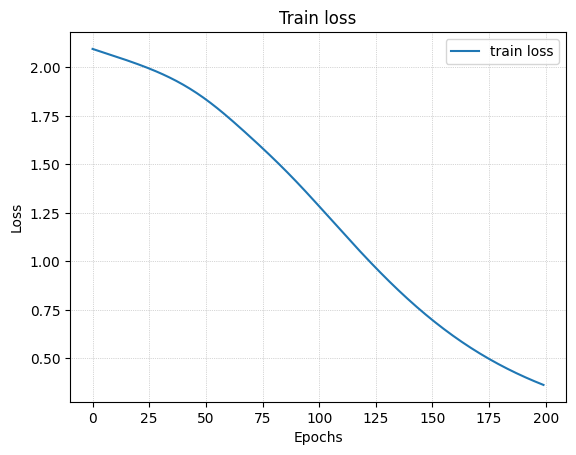

In [23]:
markers = {'train': 'o'}
x = np.arange(len(log_train_loss))
plt.plot(x, log_train_loss, label='train loss')
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim(0, 2.5)
plt.grid(True, ls=":", lw=0.5)
plt.legend(loc='upper right')

plt.show()

In [24]:
timestamp()

In [25]:
for i in a:
    now = time.strftime('%Y년 %#m월 %#d일 %#H시 %#M분 %#S초', i)
    print(now)

2023년 05월 30일 12시 46분 48초
2023년 05월 30일 12시 47분 20초
2023년 05월 30일 12시 47분 35초
2023년 05월 30일 12시 47분 44초


### 이 부분은 강의 내용과 관계 없는 부분이지만 끝까지 실행시키세요(Timestamp와 Mac address hash code 인쇄)

In [26]:
from uuid import getnode as get_mac
mac = get_mac()
mac_addr=str(mac)
import hashlib
hash_object= hashlib.sha1(mac_addr.encode('utf-8'))
signature = int(hash_object.hexdigest(), 16) % 10**8
print(str(signature))

54284998
